For this 7th tutorial we will study climate model output for different cities in the world, and look at how extreme temperature and precipitation changes over time and depending on emission scenarios

In [1]:
# #install dependencies - taken from <Yosmely Bermúdez> comments for Tutorial 6
# # We need this to install eigen which is needed for SDFC to install correctly
# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !conda install eigen
# !pip install -v https://github.com/yrobink/SDFC/archive/master.zip#subdirectory=python
# !pip install https://github.com/njleach/mystatsfunctions/archive/master.zip
# !pip install numpy
# !pip install matplotlib
# !pip install seaborn
# !pip install pandas
# !pip install cartopy
# !pip install scipy
# !pip install texttable

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import cartopy.crs as ccrs
from scipy import stats

In [3]:
import extremes_functions as ef
from mystatsfunctions import OLSE,LMoments
import SDFC as sd

In [4]:
gev = stats.genextreme

In [5]:
def estimate_return_level(quantile,model):
    loc, scale, shape = model.coef_
    level = loc - scale / shape * (1 - (-np.log(quantile))**(-shape))
    # level = stats.genextreme.ppf(quantile,-shape,loc=loc,scale=scale)
    return level

## Load CMIP6 data

## Shortcut

In [6]:
import os, pooch
fname = 'cmip6_data_city_daily_scenarios_tasmax_pr_models.nc'
if not os.path.exists(fname):
    url = "https://osf.io/ngafk/download"
    fname = pooch.retrieve(url, known_hash=None)

# data = xr.open_dataset('cmip6_data_city_daily_scenarios.nc')
data = xr.open_dataset(fname) 

SHA256 hash of downloaded file: 41ee29738ae526551dd3f4f1d123b70a9e4ef7a3a55424aaadf491be0715d8a6
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


## Through pangeo

The code below recreates the data loaded in the previous line.

In this way you can access large amounts of climate model output that has been stored in the cloud. This is very useful to get easy access to such information. Feel free to modify the code to access different data and address your own questions.

In [7]:
import intake

from xmip.preprocessing import combined_preprocessing
from xarrayutils.plotting import shaded_line_plot

from xmip.utils import google_cmip_col
# we could do all of this with pure pandas on the underlying csv file
col = google_cmip_col()

In [8]:
cat = col.search(
    # source_id=['IPSL-CM6A-LR', 'GFDL-ESM4', 'ACCESS-CM2', 'MPI-ESM1-2-LR', 'TaiESM1'],
    # source_id=['CESM2','MPI-ESM1-2-HR'],
    source_id='MPI-ESM1-2-HR',
    variable_id=['pr','tas'],
    member_id='r1i1p1f1', #
    table_id='day',
    grid_label='gn',
    experiment_id = ['historical','ssp126', 'ssp245', 'ssp585'],
    # experiment_id = ['historical', 'ssp126', 'ssp585'],
    # require_all_on = ['source_id']
)
kwargs = dict(preprocess=combined_preprocessing, xarray_open_kwargs=dict(use_cftime=True))
ds_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True})

Define one or more locations

In [9]:
sel_Hamburg = dict(lon=10,lat=53.5)
sel_Madrid = dict(lon=360-42,lat=40.5)
sel_Delhi = dict(lon=77,lat=28.5)
sel_Kinshasa = dict(lon=15,lat=-4)
sel_Phoenix = dict(lon=360-112,lat=33.5)
sel_Sydney = dict(lon=151,lat=-33.85)

sels = dict(
    Hamburg = sel_Hamburg,
    Madrid = sel_Madrid,
    Delhi = sel_Delhi,
    Kinshasa = sel_Kinshasa,
    Phoenix = sel_Phoenix,
    Sydney = sel_Sydney
)

Assemble your data

In [10]:
model = 'MPI-ESM1-2-HR'
scenarios = ['ssp126','ssp245','ssp585']
outs = []
for city in sels.keys():
    outis = []
    for scenario in scenarios:
        timeseries = xr.concat(
                    [
                        ds_dict['%s.%s' % (model, 'historical')].sel(sels[city],method='nearest').sel(time=slice('2014')),
                        ds_dict['%s.%s' % (model, scenario)].sel(sels[city],method='nearest')
                    ],'time'
                    )
        timeseries = timeseries.assign_coords(city=city,scenario=scenario).squeeze()
        outis.append(timeseries)
        # outis.append(ds_dict[key].sel(sels[city],method='nearest').assign_coords(city=city,scenario=key).squeeze())
    outs.append(xr.concat(outis,'scenario'))
data = xr.concat(outs,'city')

KeyError: 'MPI-ESM1-2-HR.historical'

In [ ]:
print('The data has %.3f MB' % data.nbytes / 1e6)

In [ ]:
with ProgressBar():
    data.load()

## Processing

Look at the data for one selected city, for one climate model

In [ ]:
city = 'Madrid'

In [ ]:
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')

In [ ]:
data_city

<xarray.Dataset>
Dimensions:         (time: 91676, scenario: 3, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-01T12:00:00 ... 2100-12-31T...
    city            <U6 'Madrid'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
    lat             float64 ...
    lat_bnds        (bnds) float64 ...
    lon             float64 ...
    lon_bnds        (bnds) float64 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
    model           <U13 'MPI-ESM1-2-HR'
Dimensions without coordinates: bnds
Data variables:
    pr              (scenario, time) float64 ...
    tasmax          (scenario, time) float32 ...
Attributes: (12/56)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        day
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:version:         20190710
    intake_esm_attrs:_data_format_:   zarr
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-HR.historical.day.gn

The data is has daily resolution, for three climate scenarios - those start in 2014, so until 2014 they are the same and then diverge

Text(0.5, 1.0, 'Precipitation')

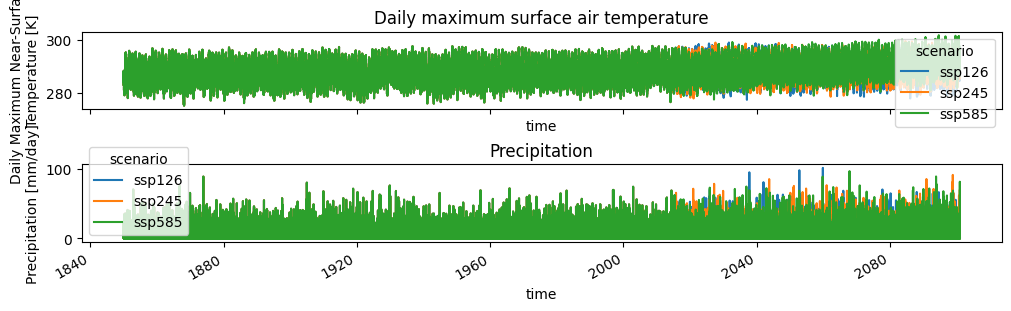

In [ ]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,3),constrained_layout=True)
data_city['tasmax'].plot(hue='scenario',ax=ax[0])
data_city['pr'].plot(hue='scenario',ax=ax[1])

ax[0].set_title('Daily maximum surface air temperature')
ax[1].set_title('Precipitation')

Do the same with a 30-year rolling mean

Text(0.5, 1.0, 'Precipitation')

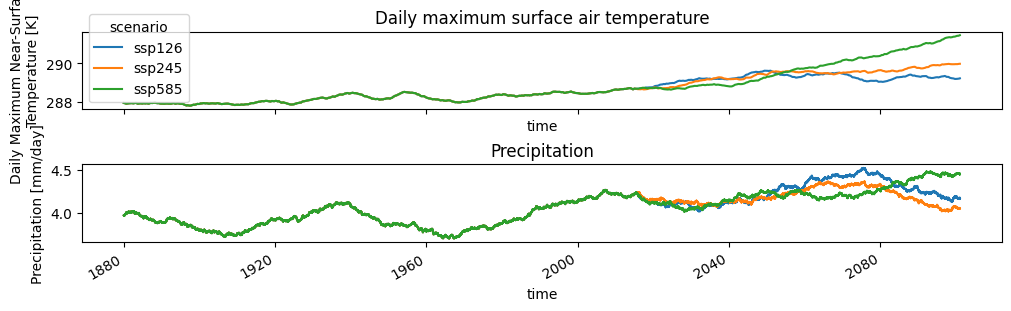

In [ ]:
fig, ax = plt.subplots(2,sharex=True,figsize=(10,3),constrained_layout=True)
data_city['tasmax'].rolling(time=30*365).mean().plot(hue='scenario',ax=ax[0])
data_city['pr'].rolling(time=30*365).mean().plot(hue='scenario',ax=ax[1],add_legend=False)

ax[0].set_title('Daily maximum surface air temperature')
ax[1].set_title('Precipitation')


In the previous tutorials we have been operating on annual maxima data. That is want to take the day in each year with the highest temperature or the largest amount of rainfall

Let's focus on precipitation for now, and compute the maximum for each year

In [ ]:
import xarray as xr
xr.DataArray(
     np.linspace(0, 11, num=12),
     coords=[
         pd.date_range(
             "1999-12-15",
             periods=12,
             freq=pd.DateOffset(months=1),
         )
     ],
     dims="time",
).resample(time="QS-DEC").mean()

TypeError: ignored

In [ ]:
pr_city = data_city['pr']
pr_city_max= pr_city.resample(time='1Y').max()

TypeError: ignored

In [ ]:
pr_city.groupby('time.year').max()

<xarray.DataArray 'pr' (scenario: 3, year: 251)>
array([[ 35.63326579,  40.72365761,  69.9846385 ,  44.36128121,
         34.34129935,  52.91912556,  51.11084227,  33.96195117,
         49.62599315,  44.51078251,  37.4308018 ,  43.83184835,
         48.57165869,  51.68603025,  40.57697263,  49.98616017,
         75.14230013,  42.33099148,  52.49345899,  65.09861592,
         46.79957516,  43.5016701 ,  47.72616439,  88.49641196,
         49.24112298,  44.25696172,  35.27506012,  55.01112789,
         30.01829926,  48.81657287,  41.73806068,  38.04536797,
         56.77314308,  50.41259117,  28.978494  ,  53.40563469,
         55.7289876 ,  54.22027521,  34.94645599,  45.77392191,
         32.38238571,  37.43649982,  54.6244774 ,  40.50830975,
         39.40459918,  43.5695434 ,  39.8866877 ,  57.63029493,
         27.81989537,  37.16394547,  42.47602187,  46.22439221,
         52.63586417,  40.70582427,  79.80849892,  65.38098715,
         41.78442936,  48.73665478,  32.19804503,  67.48396307,
         46.88663967,  53.14973686,  53.80159914,  45.04411295,
         46.89428899,  57.64330029,  55.23895305,  51.84184313,
         71.11122161,  45.07709909,  66.27836209,  58.28605983,
         52.96700802,  36.71221789,  67.98486561,  32.14429859,
         62.7524307 ,  61.25752833,  41.17272478,  75.68872143,
...
         55.06648365,  57.02562612,  38.0312562 ,  72.62887582,
         50.3129689 ,  62.21046522,  46.54481895,  59.45725646,
         53.31937987,  40.69690257,  50.72572064,  70.79433538,
         58.97582173,  61.96888536,  74.20770954,  68.92026588,
         51.87779143,  48.0929397 ,  63.72468453,  40.28953202,
         71.87903076,  65.52867293,  61.1143738 ,  54.15171795,
         36.90703176,  58.54520146,  59.95138474,  61.6545137 ,
         46.22173682,  37.41320483,  68.28540713,  58.27620775,
         48.24529756,  61.58690695,  61.60206981,  41.04631729,
         41.31990261,  88.40256818,  40.54193459,  67.20957812,
         73.46010245,  63.2148955 ,  45.10763101,  59.02124494,
         42.02669822,  96.30657881,  65.83536007,  60.70779786,
         75.90061426,  51.78817213,  54.58905715,  66.93474557,
         51.05931871,  59.24123973,  44.02720537,  64.2287001 ,
         62.49352545,  63.18030506,  43.98257174,  39.14746419,
         63.55027892,  57.10137002,  58.33831765,  50.56825317,
         68.8283734 ,  73.22693132,  56.94195125,  59.67182983,
         70.71446255,  71.4476008 ,  46.16987631,  88.65313008,
         77.13025957,  48.72280452,  67.50062462,  61.43518779,
         68.406187  ,  45.84847391,  81.09798599]])
Coordinates:
    city            <U6 'Madrid'
  * scenario        (scenario) object 'ssp126' 'ssp245' 'ssp585'
    lat             float64 ...
    lon             float64 ...
    member_id       object ...
    dcpp_init_year  float64 ...
    height          float64 ...
    model           <U13 'MPI-ESM1-2-HR'
  * year            (year) int32 1850 1851 1852 1853 ... 2097 2098 2099 2100
Attributes:
    cell_measures:  area: areacella
    cell_methods:   area: time: mean
    comment:        includes both liquid and solid phases
    history:        2019-08-25T06:42:13Z altered by CMOR: replaced missing va...
    long_name:      Precipitation
    original_name:  pr
    standard_name:  precipitation_flux
    units:          mm/day

In [ ]:
fig, ax = plt.subplots()
pr_city_max.plot(hue='scenario',ax=ax)

ax.set_title('Annual maximum precipitation')


Repeat the previous analysis: take the historical run (1850-2014), look at three 30-year periods, and compute Extreme Values. Change the periods because the historical run ends in 2014. Therefore just select one of the scenarios.

In [ ]:
data_period1 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1925','1954')).to_pandas()
data_period2 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1955','1984')).to_pandas()
data_period3 = pr_city_max.sel(scenario='ssp245',time=slice('2014')).sel(time=slice('1985','2015')).to_pandas()

In [ ]:
sns.histplot(data_period1,bins=np.arange(20,90,5),color='C0',element='step',alpha=0.5,kde=True,label='1931-1960')
sns.histplot(data_period2,bins=np.arange(20,90,5),color='C1',element='step',alpha=0.5,kde=True,label='1961-1990')
sns.histplot(data_period3,bins=np.arange(20,90,5),color='C2',element='step',alpha=0.5,kde=True,label='1991-2020')
plt.legend()

In [ ]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['1931-1960'] = [data_period1.mean(), data_period1.std(), data_period1.skew()]
periods_stats['1961-1990'] = [data_period2.mean(), data_period2.std(), data_period2.skew()]
periods_stats['1991-2020'] = [data_period3.mean(), data_period3.std(), data_period3.skew()]

periods_stats = periods_stats.T
periods_stats

In [ ]:
fit_period1, model_period1 = ef.fit_return_levels_sdfc(data_period1.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)
fit_period2, model_period2 = ef.fit_return_levels_sdfc(data_period2.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)
fit_period3, model_period3 = ef.fit_return_levels_sdfc(data_period3.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(20,90,1000)
ax.plot(x,gev.pdf(
    x, 
    -model_period1.shape.mean(), 
    loc=model_period1.loc.mean(), 
    scale=model_period1.scale.mean()
    ),
    c='C0',lw=3,label='1931-1960')
ax.plot(x,gev.pdf(
    x, 
    -model_period2.shape.mean(), 
    loc=model_period2.loc.mean(), 
    scale=model_period2.scale.mean()
    ),
    c='C1',lw=3,label='1961-1990')
ax.plot(x,gev.pdf(
    x, 
    -model_period3.shape.mean(), 
    loc=model_period3.loc.mean(), 
    scale=model_period3.scale.mean()
    ),
    c='C2',lw=3,label='1991-2020')
ax.legend()
ax.set_xlabel('annual maximum precipitation (mm/day)')
ax.set_ylabel('Density')

In [ ]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['1931-1960'] = [model_period1.loc.mean(), model_period1.scale.mean(), model_period1.shape.mean()]
parameters['1961-1990'] = [model_period2.loc.mean(), model_period2.scale.mean(), model_period2.shape.mean()]
parameters['1991-2020'] = [model_period3.loc.mean(), model_period3.scale.mean(), model_period3.shape.mean()]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

# Scenarios

Now let's look at hot days in possible climate futures: the years 2050-2080

In [ ]:
data

In [ ]:
data_city = data.sel(city=city,model='MPI-ESM1-2-HR')
# data_city = data.sel(city=city,model='ACCESS-CM2')

In [ ]:
tasmax_city_fut = data_city['tasmax'].sel(time=slice('2050','2079')).resample(time='1Y').max()

In [ ]:
sns.histplot(data=tasmax_city_fut.to_dataframe()['tasmax'].reset_index(),x='tasmax',hue='scenario',kde=True,bins=np.arange(294,302,0.5))#.plot.hist(hue='scenario')

In [ ]:
data_period1 = tasmax_city_fut.sel(scenario='ssp126').to_pandas()
data_period2 = tasmax_city_fut.sel(scenario='ssp245').to_pandas()
data_period3 = tasmax_city_fut.sel(scenario='ssp585').to_pandas()

In [ ]:
sns.histplot(data_period1,bins=np.arange(294,302,0.5),color='C0',element='step',alpha=0.5,kde=True,label='1931-1960')
sns.histplot(data_period2,bins=np.arange(294,302,0.5),color='C1',element='step',alpha=0.5,kde=True,label='1961-1990')
sns.histplot(data_period3,bins=np.arange(294,302,0.5),color='C2',element='step',alpha=0.5,kde=True,label='1991-2020')
plt.legend()

In [ ]:
periods_stats = pd.DataFrame(index=['Mean','Standard Deviation','Skew'])
periods_stats['1931-1960'] = [data_period1.mean(), data_period1.std(), data_period1.skew()]
periods_stats['1961-1990'] = [data_period2.mean(), data_period2.std(), data_period2.skew()]
periods_stats['1991-2020'] = [data_period3.mean(), data_period3.std(), data_period3.skew()]

periods_stats = periods_stats.T
periods_stats

In [ ]:
fit_period1, model_period1 = ef.fit_return_levels_sdfc(data_period1.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)
fit_period2, model_period2 = ef.fit_return_levels_sdfc(data_period2.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)
fit_period3, model_period3 = ef.fit_return_levels_sdfc(data_period3.values,times=np.arange(1.1,1000),periods_per_year=1,kind='GEV',N_boot=1000,full=True,model=True)

In [ ]:
fig, ax = plt.subplots()
x = np.linspace(293,302,1000)
ax.plot(x,gev.pdf(
    x, 
    -model_period1.shape.mean(), 
    loc=model_period1.loc.mean(), 
    scale=model_period1.scale.mean()
    ),
    c='C0',lw=3,label='1931-1960')
ax.plot(x,gev.pdf(
    x, 
    -model_period2.shape.mean(), 
    loc=model_period2.loc.mean(), 
    scale=model_period2.scale.mean()
    ),
    c='C1',lw=3,label='1961-1990')
ax.plot(x,gev.pdf(
    x, 
    -model_period3.shape.mean(), 
    loc=model_period3.loc.mean(), 
    scale=model_period3.scale.mean()
    ),
    c='C2',lw=3,label='1991-2020')
ax.legend()
ax.set_xlabel('annual maximum daily maximum temperature (K)')
ax.set_ylabel('Density')

In [ ]:
parameters = pd.DataFrame(index=['Location', 'Scale', 'Shape'])
parameters['1931-1960'] = [model_period1.loc.mean(), model_period1.scale.mean(), model_period1.shape.mean()]
parameters['1961-1990'] = [model_period2.loc.mean(), model_period2.scale.mean(), model_period2.shape.mean()]
parameters['1991-2020'] = [model_period3.loc.mean(), model_period3.scale.mean(), model_period3.shape.mean()]

parameters = parameters.T
parameters.round(4)#.astype('%.2f')

In [ ]:
ef.plot_levels_from_obj(fit_period1,alpha=0.95)
ef.plot_levels_from_obj(fit_period2,alpha=0.95,ax=plt.gca(),c='C1')
ef.plot_levels_from_obj(fit_period3,alpha=0.95,ax=plt.gca(),c='C2')
# plt.xlim(1.5,1000)
# plt.ylim(0,None)
# plt.semilogx()

# Potential add-on: spatial analysis

TBD